# Cart Pole DQN Solution

![cart_pole](../images/lecture_3/cart_pole.png)


## Gym Description

### Description

This environment corresponds to the version of the cart-pole problem described by Barto, Sutton, and Anderson in
["Neuronlike Adaptive Elements That Can Solve Difficult Learning Control Problem"](https://ieeexplore.ieee.org/document/6313077).
A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track.
The pendulum is placed upright on the cart and the goal is to balance the pole by applying forces
in the left and right direction on the cart.

### Action Space

The action is a `ndarray` with shape `(1,)` which can take values `{0, 1}` indicating the direction
of the fixed force the cart is pushed with.

- 0: Push cart to the left
- 1: Push cart to the right

**Note**: The velocity that is reduced or increased by the applied force is not fixed and it depends on the angle
the pole is pointing. The center of gravity of the pole varies the amount of energy needed to move the cart underneath it

### Observation Space

The observation is a `ndarray` with shape `(4,)` with the values corresponding to the following positions and velocities:

| Num | Observation           | Min                 | Max               |
| --- | --------------------- | ------------------- | ----------------- |
| 0   | Cart Position         | -4.8                | 4.8               |
| 1   | Cart Velocity         | -Inf                | Inf               |
| 2   | Pole Angle            | ~ -0.418 rad (-24°) | ~ 0.418 rad (24°) |
| 3   | Pole Angular Velocity | -Inf                | Inf               |

**Note:** While the ranges above denote the possible values for observation space of each element,
it is not reflective of the allowed values of the state space in an unterminated episode. Particularly:

- The cart x-position (index 0) can be take values between `(-4.8, 4.8)`, but the episode terminates
  if the cart leaves the `(-2.4, 2.4)` range.
- The pole angle can be observed between `(-.418, .418)` radians (or **±24°**), but the episode terminates
  if the pole angle is not in the range `(-.2095, .2095)` (or **±12°**)

### Rewards

Since the goal is to keep the pole upright for as long as possible, a reward of `+1` for every step taken,
including the termination step, is allotted. The threshold for rewards is 475 for v1.

### Starting State

All observations are assigned a uniformly random value in `(-0.05, 0.05)`

### Episode End

The episode ends if any one of the following occurs:

1. Termination: Pole Angle is greater than ±12°
2. Termination: Cart Position is greater than ±2.4 (center of the cart reaches the edge of the display)
3. Truncation: Episode length is greater than 500 (200 for v0)

### Arguments

```python
import gymnasium as gym
gym.make('CartPole-v1')
```

On reset, the `options` parameter allows the user to change the bounds used to determine
the new random state.
"""


## Set Jupyter Environment

In [34]:
import matplotlib.pyplot as plt
import matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display
plt.ion()

## Import Env


In [35]:
import gymnasium as gym
from gymnasium.envs.classic_control.cartpole import CartPoleEnv
for k, v in gym.envs.registry.items():
    print(str(k)+"\t"+str(v))


CartPole-v0	EnvSpec(id='CartPole-v0', entry_point='gymnasium.envs.classic_control.cartpole:CartPoleEnv', reward_threshold=195.0, nondeterministic=False, max_episode_steps=200, order_enforce=True, autoreset=False, disable_env_checker=False, apply_api_compatibility=False, kwargs={}, namespace=None, name='CartPole', version=0, additional_wrappers=(), vector_entry_point='gymnasium.envs.classic_control.cartpole:CartPoleVectorEnv')
CartPole-v1	EnvSpec(id='CartPole-v1', entry_point='gymnasium.envs.classic_control.cartpole:CartPoleEnv', reward_threshold=475.0, nondeterministic=False, max_episode_steps=500, order_enforce=True, autoreset=False, disable_env_checker=False, apply_api_compatibility=False, kwargs={}, namespace=None, name='CartPole', version=1, additional_wrappers=(), vector_entry_point='gymnasium.envs.classic_control.cartpole:CartPoleVectorEnv')
MountainCar-v0	EnvSpec(id='MountainCar-v0', entry_point='gymnasium.envs.classic_control.mountain_car:MountainCarEnv', reward_threshold=-110.

In [36]:
env = gym.make("CartPole-v1")
print("Observation space: ", env.observation_space)
print("Observation shape: ",env.observation_space.shape)
print("Action space: ", env.action_space)

Observation space:  Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)
Observation shape:  (4,)
Action space:  Discrete(2)


## Experience


In [37]:
from collections import deque
import random
from typing import List


class Experience:
    def __init__(self, maxlen: int) -> None:
        # maxlen: if the deque is full, stored items will pop from the head
        self.experience = deque([], maxlen=maxlen)

    def append(self, transition: List) -> None:
        self.experience.append(transition)

    def sample(self, batch_size) -> List:
        return random.sample(self.experience, batch_size)

    def get_length(self) -> int:
        return len(self.experience)


## Q network


In [38]:

import torch
import torch.nn as nn


class DQN(nn.Module):
    def __init__(self, num_observations: int, num_actions: int) -> None:
        super().__init__()
        self.linear_1 = nn.Linear(num_observations, 128)
        self.linear_2 = nn.Linear(128, 128)
        self.linear_3 = nn.Linear(128, num_actions)
        self.selu = nn.SELU()

    def forward(self, state: torch.Tensor) -> torch.Tensor:
        q_actions = self.linear_1(state)
        q_actions = self.selu(q_actions)
        q_actions = self.linear_2(q_actions)
        q_actions = self.selu(q_actions)
        q_actions = self.linear_3(q_actions)
        return q_actions


## Epsilon Decay

In [39]:
import numpy as np


def get_epsilon(epsilon_start: float, epsilon_end: float, epsilon_decay: int, step_decay: int):
    """return epsilon: epsilon_end+(epsilon_start-epsilon_end)*e**(-step_decay/epsilon_decay)"""
    return epsilon_end+(epsilon_start-epsilon_end)*np.exp(-1.0*step_decay/epsilon_decay)


## Epsilon-greedy

In [40]:
def epsilon_greedy(q_approximator: nn.Module, state: torch.Tensor, num_actions: int, epsilon: float):
    q_actions = q_approximator(state).detach().cpu().numpy()
    probability = np.ones(num_actions)*epsilon/num_actions
    idx_action_with_max_q = np.argmax(q_actions)
    probability[idx_action_with_max_q] = 1-np.sum(probability[1:])
    return np.random.choice(np.arange(num_actions), p=probability)


epsilon_greedy(DQN(env.observation_space.shape[0], env.action_space.n), torch.tensor(
    env.reset()[0]), env.action_space.n, 0.1)


1

## Update DQN

In [41]:
def update_dqn(policy_net:DQN,target_net:DQN,experience:Experience,batch_size:int,gamma:float,loss_fn:nn.Module,optimizer:torch.optim.Optimizer,device:str):
    batch=experience.sample(batch_size)
    [batch_state,batch_action,batch_next_state,batch_reward]=zip(*batch)
    non_final_mask = torch.tensor([next_state is not None for next_state in batch_next_state], dtype=torch.bool,device=device)
    non_final_next_states=torch.tensor([next_state for next_state in batch_next_state if next_state is not None],dtype=torch.float32,device=device)
    batch_state=torch.tensor(batch_state,dtype=torch.float32,device=device)
    batch_action=torch.tensor(batch_action,device=device).unsqueeze(-1)
    batch_reward=torch.tensor(batch_reward,dtype=torch.float32,device=device).unsqueeze(-1)
    q_state_action=policy_net(batch_state).gather(1,batch_action)
    q_next_state_action=torch.zeros(q_state_action.size()).to(device)
    with torch.no_grad():
        q_next_state_action[non_final_mask]=target_net(non_final_next_states).max(1)[0].unsqueeze(-1)
    q_target=batch_reward+gamma*q_next_state_action
    
    
    optimizer.zero_grad()
    loss=loss_fn(q_state_action,q_target)
    loss.backward()
    optimizer.step()
    

## Test DQN

In [42]:
def test_dqn(env:gym.Env,q_approximator:DQN,device:str):
    duration=0
    state=env.reset()[0]
    is_terminated=False
    while not is_terminated:
        qs_state_action=q_approximator(torch.tensor(state,device=device))
        action=torch.argmax(qs_state_action).detach().cpu().item()
        next_state,reward,is_terminated,is_truncated,info=env.step(action)
        state=next_state
        duration+=1
        if duration>=2000:
            break
    print("duration: ",duration)
        

## Q-learning

In [43]:
from collections import defaultdict


def q_learning(env: gym.Env, num_episodes: int, experience_len: int = 128, batch_size: int = 64, alpha: float = 1e-4, gamma: float = 0.9, epsilon_start: float = 0.9, epsilon_end: float = 0.05, tau=0.005, epsilon_decay: int = 1000, device: str = "cpu", print_step=100):

    policy_net = DQN(
        env.observation_space.shape[0], env.action_space.n).to(device)
    target_net = DQN(
        env.observation_space.shape[0], env.action_space.n).to(device)
    target_net.load_state_dict(policy_net.state_dict())
    loss_fn = nn.MSELoss()
    optimizer = torch.optim.SGD(policy_net.parameters(), lr=alpha)

    num_durations_per_episode = defaultdict(int)

    experience = Experience(maxlen=experience_len)

    step_epsilon_decay = 0

    for episode_i in range(num_episodes):
        state = env.reset()[0]
        is_terminated = False
        while not is_terminated:
            epsilon = get_epsilon(epsilon_start, epsilon_end,
                                  epsilon_decay, step_epsilon_decay)
            step_epsilon_decay += 1
            action = epsilon_greedy(policy_net, torch.tensor(
                state, device=device), env.action_space.n, epsilon)
            next_state, reward, is_terminated, is_truncated, info = env.step(
                action)
            if is_terminated:
                next_state = None
            experience.append([state, action, next_state, reward])
            state = next_state

            if experience.get_length() >= batch_size:
                update_dqn(policy_net, target_net, experience, batch_size,
                           gamma, loss_fn, optimizer, device)

            target_net_state_dict = target_net.state_dict()
            policy_net_state_dict = policy_net.state_dict()
            for key in policy_net_state_dict:
                target_net_state_dict[key] = policy_net_state_dict[key] * \
                    tau + target_net_state_dict[key]*(1-tau)
            target_net.load_state_dict(target_net_state_dict)

            num_durations_per_episode[episode_i] += 1
            
            if num_durations_per_episode[episode_i]>=1000:
                break
    
        if episode_i % print_step == 0:
            print("-------- episode %d ---------" % episode_i)
            test_dqn(env, policy_net, device)
    return policy_net,num_durations_per_episode


In [44]:
policy_net,num_durations_per_episode=q_learning(env, 1500, experience_len=2**10, batch_size=64, alpha=1e-3, gamma=0.9, epsilon_start=0.9, epsilon_end=0.05, epsilon_decay=1000, tau=0.005,
           device="cuda" if torch.cuda.is_available() else "cpu")


-------- episode 0 ---------
duration:  10
-------- episode 100 ---------
duration:  26
-------- episode 200 ---------
duration:  28
-------- episode 300 ---------
duration:  89
-------- episode 400 ---------
duration:  149
-------- episode 500 ---------
duration:  193
-------- episode 600 ---------
duration:  169
-------- episode 700 ---------
duration:  46
-------- episode 800 ---------
duration:  518
-------- episode 900 ---------
duration:  199
-------- episode 1000 ---------
duration:  191
-------- episode 1100 ---------
duration:  197
-------- episode 1200 ---------
duration:  209
-------- episode 1300 ---------
duration:  191
-------- episode 1400 ---------
duration:  166


## Plot result

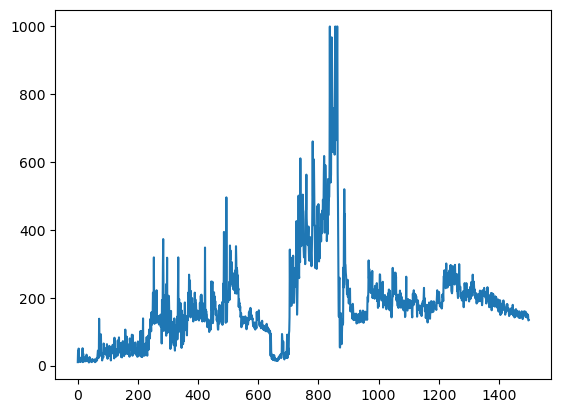

In [45]:
from typing import Dict
def plot_num_durations_per_episode(num_durations_per_episode:Dict):
    fig,ax=plt.subplots()
    ax.plot(num_durations_per_episode.keys(),num_durations_per_episode.values())
plot_num_durations_per_episode(num_durations_per_episode)